In [39]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime, timedelta


In [2]:
# data_reshape = data.reshape((10, pred_data.shape[1]*pred_data.shape[3]))
# print(f"reshape data to (files, all hours) {data_reshape.shape}") # start from 1/8 00:00, ..., 23:00, 1/9 00:00,...

In [3]:
def read_multiple_imputations(folder_path, missing_k):
    """
    goal: read multiple imputations that are generated from 'inference_multiples.py', shape (obs, channel, length)
    output: return an array, shape (number of imputation files, obs, channel, missing_k)
    input:
        folder_path = the folder that contains the file we want to read
        missing_k = same 'missing_k' in config file, i.e, the number of the last elements to be predicted, ex: 24 in my case
    """
    # Check if the folder exists
    if not os.path.exists(folder_path):
        print(f"Folder '{folder_path}' does not exist.")
        return

    # Get a list of files in the folder
    file_list = os.listdir(folder_path)

    # Filter out only imputation0.npy files
    npy_files = [file for file in file_list if file.endswith("imputation0.npy")]

    if not npy_files:
        print(f"No imputation0.npy files found in '{folder_path}'.")
        return

    # Loop through the all imputation0.npy files and read them
    stack_array_data = None
    for npy_file in npy_files:
        array_data = read_missing_k_data(folder_path, npy_file, missing_k)
        array_data = array_data.reshape(tuple([1]) + array_data.shape) # array_data.shape = (obs, channel, length) -> (1, obs, channel, length)

        if stack_array_data is None:
            stack_array_data = array_data
        else:
            stack_array_data = np.vstack((stack_array_data, array_data))

    # print(f"return (1) Load and stack all imputation0.npy files, shape: {stack_array_data.shape} = (files, obs, channels, length)")

    return stack_array_data



def read_missing_k_data(folder_path, npy_file, missing_k):
    """
    goal: return the last 24 elements of each observation
    output: an array, shape (obs, channel, length = missing_k)
    input:
        folder_path = the folder that contains the file we want to read
        npy_file = the file name that we want to read, ex: "original0.npy"
        missing_k = same'missing_k' in config file, i.e, the number of the last elements to be predicted, ex: 24 in my case
    """
    file_path = os.path.join(folder_path, npy_file)
    true = np.load(file_path)
    true = true[:,:,(-missing_k):]
    # print(f"return test data with imputation, shape{true.shape}")
    return true  
def pred_interval(pred, beta):
    """
    goal: compute the (1-alpha) quantile of imputation ecdf, i.e, prediction interval
    output: lower bound and upper bound, shape: (obs, channel, length)
    input:
        pred = all data, shape(number of imputation files, obs, channel, length)
        beta = significance level of original prediction interval
    """
    beta = 0.05
    # compute original prediciton intervals
    L = np.quantile(pred_data, 0.025, axis=0)
    U = np.quantile(pred_data, 0.975, axis=0)

    return L, U

def compute_E_star(L, U, true, alpha):
    """
    goal: compute the (1-alpha) quantile of conformity scores, i.e, E_star
    output: E_star, shape: (channel, length)
    input:
        L = lower bound to be adjusted, shape: (obs, channel, length)
        U = upper bound to be adjusted, shape: (obs, channel, length)        
        alpha = miscoverage rate of conformal prediction
    """

    alpha = 0.05

    # compute the conformity scores
    E = np.maximum(L-true, true-U)
    
    # compute the (1-alpha) quantile of conformity scores
    CP_PAR = (1+1/true.shape[0])*(1-alpha)
    E_star = np.quantile(E, CP_PAR, axis=0)

    return E_star

def adjust_PI(L, U, E_star):
    """
    goal: adjust prediction interval using conformal prediction
    output: adjusted lower and upper bound, shape: (obs, channel, length)
    input: 
        L = lower bound to be adjusted, shape: (obs, channel, length)
        U = upper bound to be adjusted, shape: (obs, channel, length)
        E_star = scores, shape: (channel, length)
    """
    E_star_exd = np.expand_dims(E_star, axis=0)
    return L-E_star_exd, U+E_star_exd

def coverage_rate(L, U, true):
    """
    goal: compute the coverage rate, which is the proportion of [L,U] contains true data 
    output: an array, shape (shape, length)
    input:
        L = lower bound, shape: (2209, 1, 24)
        U = upper bound, shape: (2209, 1, 24)
        true = true data, shape: (2209, 1, 24)
    """
    return np.sum(np.logical_and(true_data > L, true_data < U), axis=0)/true.shape[0]

def generate_date_from_seq(value):
    """
    goal: what is the date of given number of obs
    output: date
    input: a value (obs)
    """
    start_date = datetime.strptime("2019-01-08", "%Y-%m-%d")
    days_offset = value
    target_date = start_date + timedelta(days=days_offset)
    formatted_date = target_date.strftime("%Y/%m/%d")
    
    return formatted_date


# I_2

In [9]:
folder_path = "/home/hchuang/Documents/UQ-DL/SSSD/src/results/NYISO_NYC_split/T200_beta00.0001_betaT0.02/imputaiton_multiple/"
pred_data = read_multiple_imputations(folder_path, 24)
true_data = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 24)

print(f"pred_data, shape: {pred_data.shape}")
print(f"true_data, shape: {true_data.shape}")

pred_data, shape: (48, 2209, 1, 24)
true_data, shape: (2209, 1, 24)


In [10]:
L, U = pred_interval(pred_data, beta = 0.05)
E_star = compute_E_star(L, U, true_data, alpha = 0.05)
L_star, U_star = adjust_PI(L, U, E_star)

In [11]:
coverage_rate(L, U, true_data)

array([[0.16659122, 0.18062472, 0.18786781, 0.18741512, 0.19692168,
        0.19511091, 0.20099593, 0.18650973, 0.17564509, 0.1674966 ,
        0.16478044, 0.16251698, 0.14486193, 0.15301041, 0.15889543,
        0.15210502, 0.14938886, 0.15980081, 0.15617927, 0.15708465,
        0.15255772, 0.15029425, 0.13942961, 0.14893617]])

In [12]:
coverage_rate(L_star, U_star, true_data)

array([[0.95020371, 0.95020371, 0.95020371, 0.95020371, 0.95020371,
        0.95020371, 0.95020371, 0.95020371, 0.95020371, 0.95020371,
        0.95020371, 0.95020371, 0.95020371, 0.95020371, 0.95020371,
        0.95020371, 0.95020371, 0.95020371, 0.95020371, 0.95020371,
        0.95020371, 0.95020371, 0.95020371, 0.95020371]])

# Test data

## adjusted pred interval

In [13]:
folder_path = "/home/hchuang/Documents/UQ-DL/SSSD/src/results/NYISO_NYC_split/T200_beta00.0001_betaT0.02/imputaiton_multiple_test/"
pred_data = read_multiple_imputations(folder_path, 24)
true_data = read_missing_k_data(folder_path, npy_file="original0.npy", missing_k = 24)

print(f"pred_data, shape: {pred_data.shape}")
print(f"true_data, shape: {true_data.shape}")

pred_data, shape: (10, 358, 1, 24)
true_data, shape: (358, 1, 24)


In [14]:
L, U = pred_interval(pred_data, beta = 0.05)
L_star, U_star = adjust_PI(L, U, E_star)

## coverage rate

In [82]:
cr = coverage_rate(L, U, true_data)
cr_star = coverage_rate(L_star, U_star, true_data)

In [56]:
base_time = datetime.strptime("00:00", "%H:%M")
# Create a list of 24 elements by adding 1 hour to the base time in each iteration
hours_sequence = [base_time + timedelta(hours=i) for i in range(24)]
# Format the elements as strings in the desired format (HH:MM)
formatted_sequence = [time.strftime("%H:%M") for time in hours_sequence]


## vis

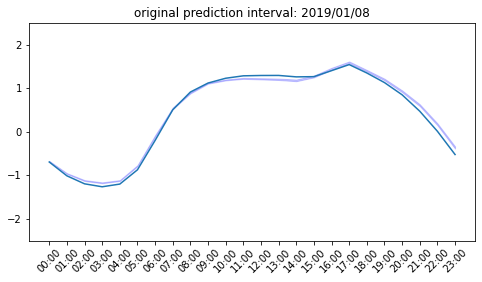

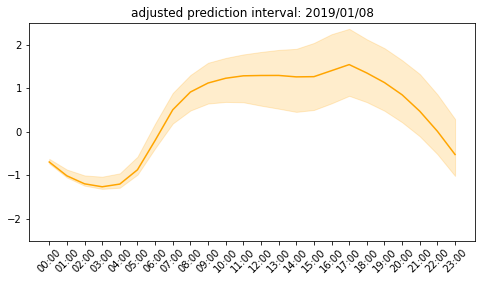

In [109]:
obs = 0
date = generate_date_from_sequence(obs)

x = formatted_sequence
y = true_data[obs,0,:]
lower = L[obs,0,:]
upper = U[obs,0,:]

plt.figure(figsize=(8, 4)) 
plt.plot(x, y)
plt.title("original prediction interval: " +date)
plt.xticks(rotation=45) 
plt.fill_between(x, lower, upper, color='blue', alpha=0.2)
plt.ylim(-2.5, 2.5) 
plt.show()

lower = L_star[obs,0,:]
upper = U_star[obs,0,:]

plt.figure(figsize=(8, 4)) 
plt.plot(x, y, color = 'orange')
plt.title("adjusted prediction interval: " + date)
plt.xticks(rotation=45) 
plt.fill_between(x, lower, upper, color='orange', alpha=0.2)
plt.ylim(-2.5, 2.5) 
plt.show()

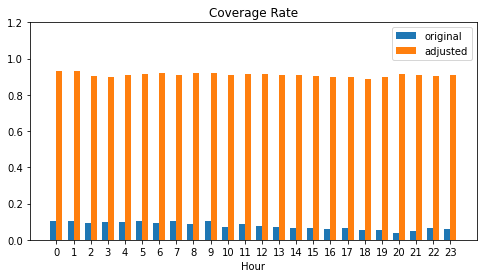

In [100]:
a = cr
b = cr_star

# Generate x values (assuming 24 hours)
x = np.arange(24)

# Set the width of the bars
bar_width = 0.35


# Plotting
plt.figure(figsize=(8,4))
plt.bar(x - bar_width/2, a.flatten(), bar_width, label='original')
plt.bar(x + bar_width/2, b.flatten(), bar_width, label='adjusted')

# Customize the plot

plt.xlabel('Hour')
plt.ylabel('')
plt.title('Coverage Rate')
plt.xticks(x)
plt.legend()
plt.ylim(0, 1.2) 
# Show the plot
plt.show()
